In [79]:
import string
import pandas as pd
import numpy as np
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import word_tokenize
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

1(+6). Проверить, сбалансирован ли датасет (может быть, наблюдений одного класса слишком много?). Какие результаты покажет dummy classifier, который будет всем новым наблюдениям присваивать класс ham? Насколько плохо такое решение для задачи определения спама?<br />
Грубое решение - включить в training set только необходимое число наблюдений (примерно поровну spam и ham). <br />
Нормализовать тексты и обучить байесовскую модель (bag of words). Проверить, как влияют на результат:<br />

1) разная токенизация: в одном случае знаки препинания удалять, в другом — считать их токенами;<br />
2) лемматизация (отсутствие лемматизации, стемминг, лемматизация; инструменты можно использовать любые, например, nltk.stem);<br />
3) удаление стоп-слов, а также пороги минимальной и максимальной document frequency;<br />
4) векторизация документов (CountVectorizer vs. TfIdfVectorizer);<br />
5) что-нибудь ещё?<br />

При оценке классификатора обратите внимание на TP и FP.

Extra: ограничив количество наблюдений ham в обучающей выборке, мы игнорируем довольно много данных. 1) В цикле: случайно выбрать нужное число писем ham и сконструировать сбалансированную выборку, построить классификатор, оценить и записать результат; в итоге результаты усреднить. 2) поможет ли параметр class prior probability?

In [2]:
path = 'smsspamcollection/SMSSpamCollection'

messages = pd.read_csv(path, sep='\t',
                           names=["label", "message"])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Загрузили, посмотрели. Смотрим на классы

In [3]:
print(messages.groupby('label').describe())

                                                        message
label                                                          
ham   count                                                4825
      unique                                               4516
      top                                Sorry, I'll call later
      freq                                                   30
spam  count                                                 747
      unique                                                653
      top     Please call our customer service representativ...
      freq                                                    4


Выборка очевидно несбалансирована по классам (~6:1). Соответственно, dummy-classifier, всегда присваивающий ярлык "ham", будет иметь accuracy ~86%, а confusion matrix будет выглядеть вот так:

In [4]:
d = {'clf_ham': pd.Series([4825, 747], index=['ham', 'spam']),
    'clf_spam': pd.Series([0, 0], index=['ham', 'spam'])}
pd.DataFrame(d)

,clf_ham,clf_spam
ham,4825,0
spam,747,0


Для задачи определения спама классификатор, который никогда не определяет спам, абсолютно бесполезен просто по определению.

In [ ]:
ham = messages.loc[messages['label']=='ham']
spam = messages.loc[messages['label']=='spam']

In [24]:
# и да, мне всё равно, что он работает только на существительных
lm = WordNetLemmatizer()
st = LancasterStemmer()

def nopunct(strin):
    res = [x.strip(string.punctuation) for x in strin.split()]
    return res

parameters = {'vect__stop_words': [None, 'english'],
              'vect__min_df': [1, 3],
              'vect__max_df': [1.0, 0.6], 
              'vect__tokenizer': [nopunct, word_tokenize],
              'vect__preprocessor': [None, lm.lemmatize, st.stem]}

In [70]:
shdata = []
paramset = []
for i in range(6):
    shard = pd.concat([ham.sample(n=747), spam]).sample(frac=1) # это я случайно выбираю строчки и перемешиваю
    print('Training for shard {}'.format(i))
#     X_train, X_test, y_train, y_test = train_test_split(shard['message'], shard['label'])
    X, y = shard['message'], shard['label']
    CV_clf = Pipeline([('vect', CountVectorizer()),
                       ('tfidf', TfidfTransformer()), 
                       ('clf', MultinomialNB()),])
    TI_clf = Pipeline([('vect', TfidfVectorizer()),
                       ('tfidf', TfidfTransformer()), 
                       ('clf', MultinomialNB()),])
    
    gs_cv = GridSearchCV(CV_clf, parameters)
    gs_ti = GridSearchCV(TI_clf, parameters)
    
    print('tuning with CountVectorizer...')
    gs_cv = gs_cv.fit(X, y)
    print('tuning with TfidfVectorizer...')
    gs_ti = gs_ti.fit(X, y)
    print('all fitted')
        
#     print('Predicting...')
#     praed_cv, praed_ti = gs_cv.predict(X_test), gs_ti.predict(X_test)
    
    shdata.append(gs_cv.cv_results_)
    shdata.append(gs_ti.cv_results_)
    print()
    
print('all done')

Training for shard 0
tuning with CountVectorizer...
tuning with TfidfVectorizer...
all fitted
Predicting...

Training for shard 1
tuning with CountVectorizer...
tuning with TfidfVectorizer...
all fitted
Predicting...

Training for shard 2
tuning with CountVectorizer...
tuning with TfidfVectorizer...
all fitted
Predicting...

Training for shard 3
tuning with CountVectorizer...
tuning with TfidfVectorizer...
all fitted
Predicting...

Training for shard 4
tuning with CountVectorizer...
tuning with TfidfVectorizer...
all fitted
Predicting...

Training for shard 5
tuning with CountVectorizer...
tuning with TfidfVectorizer...
all fitted
Predicting...

all done


In [28]:
len(shdata)

12

Ура, есть cv_results для всего. Теперь усреднять

In [30]:
paramset = shdata[0]['params']

In [33]:
cv = np.array([shdata[x]['mean_test_score'] for x in range(1, 6, 2)]).mean(axis=0)
tf = np.array([shdata[x]['mean_test_score'] for x in range(2, 7, 2)]).mean(axis=0)
cv

array([ 0.95091477,  0.95560018,  0.94042838,  0.9453369 ,  0.94578313,
        0.95069166,  0.94712182,  0.94823739,  0.95113788,  0.95560018,
        0.94042838,  0.9453369 ,  0.94087461,  0.94689871,  0.93105756,
        0.93663543,  0.93507363,  0.94065149,  0.93351183,  0.94109772,
        0.94065149,  0.94645248,  0.93038822,  0.93663543,  0.95091477,
        0.95560018,  0.94042838,  0.9453369 ,  0.94578313,  0.95069166,
        0.94712182,  0.94823739,  0.95113788,  0.95560018,  0.94042838,
        0.9453369 ,  0.94087461,  0.94689871,  0.93105756,  0.93663543,
        0.93507363,  0.94065149,  0.93351183,  0.94109772,  0.94065149,
        0.94645248,  0.93038822,  0.93663543])

In [54]:
paramset[0]
parset = [','.join(list(map(lambda x: '{}'.format(st[x]), st))) for st in paramset]
parset = list(map(lambda x: x.replace('<function nopunct at 0x1177966a8>', 'nopunct'), parset))
parset = list(map(lambda x: x.replace('<function word_tokenize at 0x116ff2ae8>', 'punct'), parset))
parset = list(map(lambda x: x.replace('<bound method WordNetLemmatizer.lemmatize of <WordNetLemmatizer>>', 'lemm'), parset))
parset = list(map(lambda x: x.replace('<bound method LancasterStemmer.stem of <LancasterStemmer>>', 'stem'), parset))
parset[0]

'1,None,1.0,nopunct,None'

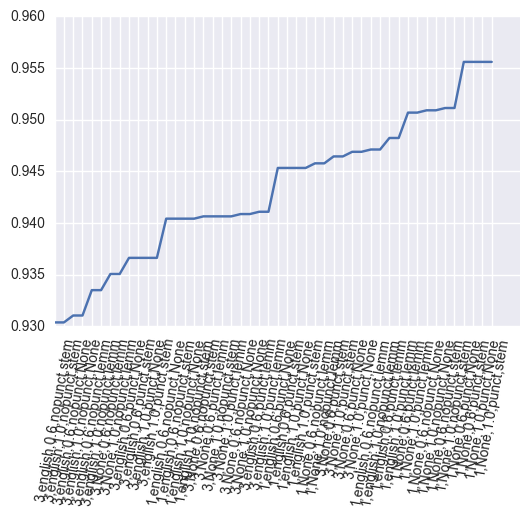

In [69]:
cv_y, cv_x = zip(*sorted(zip(cv, parset)))
plt.plot(list(range(len(cv_x))), list(cv_y))
plt.xticks(list(range(len(cv_x))), list(cv_x), rotation=80)
plt.show;

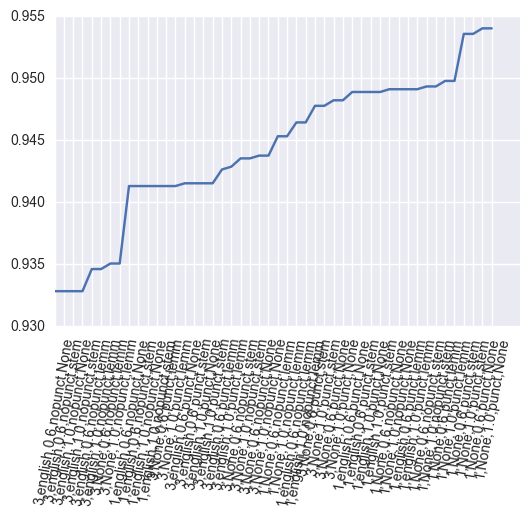

In [68]:
tf_y, tf_x = zip(*sorted(zip(tf, parset)))
plt.plot(list(range(len(tf_x))), list(tf_y))
plt.xticks(list(range(len(tf_x))), list(tf_x), rotation=80)
plt.show;

Разумеется, здесь ничего не видно, но суть в том, что CountVectorizer лучше, чем TfidfVectorizer, но на какие-то десятые процента, а самый лучшие настройки - заводские: минимальный df лучше не ограничивать, это даёт от полпроцента до процента бонуса, токенизация пунктуации тоже даёт от полпроцента до процента, использование стоп-слов снижает результат на полпроцента; лемматизация держит середину, а лучшие (и худшие) результаты достигаются при стемматизации и просто токенизации без предобработки. Максимальный df, кажется, не влияет никак. И в целом разброс результатов не очень большой - до 3%, при этом отрыв от dummy-классификатора гораздо более значительный  - 7-10%.

2(+2). Сравнить результаты <br />
- байесовского классификатора, <br />
- решающего дерева <br />
- и RandomForest. <br />
Помимо стандартных метрик оценки качества модели, необходимо построить <br />
- learning curve, <br />
- ROC-curve, <br />
- classification report <br />
и интерпретировать эти результаты.

In [ ]:
# общая функция для всего, всё как я люблю
def rocing(clf, name):
    stat = []
    # это цвета для кривых
    colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
    lw = 2

    for i, color in zip(list(range(6)), colors): # это я всё так же беру шесть шардов
        shard = pd.concat([ham.sample(n=747), spam]).sample(frac=1) # снова случайно выбираю строчки и перемешиваю

        print('Training {} for shard {}'.format(name, i))

        X_train, X_test, y_train, y_test = train_test_split(shard['message'], shard['label'])
        # векторайзер в той конфигурации, которая победила в прошлом раунде
        vect = CountVectorizer(tokenizer=word_tokenize, preprocessor=st.stem)
        vect = vect.fit(X_train)
        X_train = vect.transform(X_train)
        X_test = vect.transform(X_test)
        clf.fit(X_train, y_train)
        
        # вероятности для roc, предсказания для f1-score
        probas_ = clf.predict_proba(X_test)
        praed = clf.predict(X_test)
        y_true = pd.get_dummies(y_test, drop_first=True)
        praed_d = pd.get_dummies(praed, drop_first=True)
        fpr, tpr, thresholds = roc_curve(y_true, probas_[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=lw, color=color,
                 label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
        # записываем получившуюся f-меру в массив, чтобы потом взять среднее
        treestat.append(f1_score(y_true, praed_d))

    print('F1-score mean of all shards is')
    print('\t{}'.format(np.array(treestat).mean()))

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for {}'.format(name))
    plt.legend(loc="lower right")
    plt.show();

Training Naive Bayes for shard 0
Training Naive Bayes for shard 1
Training Naive Bayes for shard 2
Training Naive Bayes for shard 3
Training Naive Bayes for shard 4
Training Naive Bayes for shard 5
F1-score mean of all shards is
	0.9299764288518205


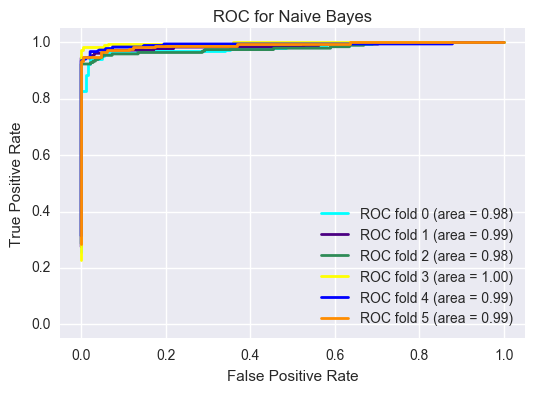

In [117]:
nb = MultinomialNB()
    
rocing(nb, 'Naive Bayes')

O_O

Training tree for shard 0
Training tree for shard 1
Training tree for shard 2
Training tree for shard 3
Training tree for shard 4
Training tree for shard 5
F1-score mean of all shards is
	0.9141681024717188


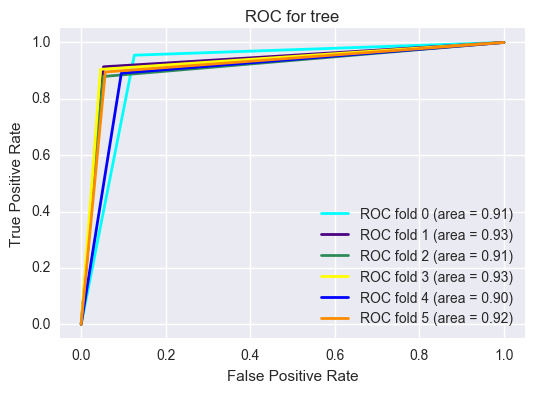

In [116]:
tree = DecisionTreeClassifier(random_state=6)

rocing(tree, 'tree')

Training Random Forest for shard 0
Training Random Forest for shard 1
Training Random Forest for shard 2
Training Random Forest for shard 3
Training Random Forest for shard 4
Training Random Forest for shard 5
F1-score mean of all shards is
	0.9292162317206047


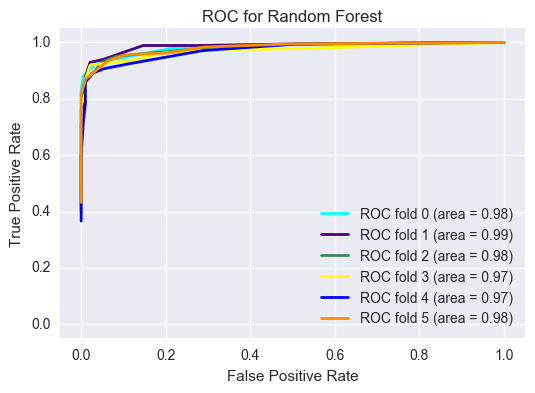

In [118]:
forest = RandomForestClassifier(random_state=6)
    
rocing(forest, 'Random Forest')

У наивного байеса какие-то космические ROC-кривые, очевидно, что он справляется с задачей лучше всего (на одном шарде даже AUC=1.0). Лес догоняет и по f-мере, и по AUC. У обоих классификаторов шарды не слишком различались: амплитуда всего 2%. Хуже всего справилось дерево: у него и f-мера ниже (на 1.5%, правда), и AUC ниже на 4-10%, и вариативность чуть больше - 3%. К тому же, как видно по наклону, оно учится медленнее всего.

3(+2). А что, если в качестве предикторов брать не количество вхождений слов, а конструировать специальные признаки? Прежде всего, необходимо разделить таблицу на training set и test set в соотношении 80:20, test set не открывать до этапа оценки модели. С помощью pandas проверить, отличаются ли перечисленные ниже параметры (иможно придумать другие) для разных классов (spam/ham), и собрать матрицу признаков для обучения. Примеры признаков: длина сообщения, количество букв в ВЕРХНЕМ РЕГИСТРЕ, восклицательных знаков, цифр, запятых, каких-то конкретных слов (для этого можно построить частотный словарь по сообщениям каждого класса). Прокомментировать свой выбор. Векторизовать документы и построить классификатор. Оценить модель на проверочной выборке.